Import modules

In [1]:
%matplotlib inline
import os
from os.path import join, exists, expandvars
import pandas as pd
from IPython.display import display, Markdown
import seaborn
#import seaborn.xkcd_rgb as colors
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           boxplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           beta_diversity_pcoa,
                                           average_distance_boxplots,
                                           rank_optimized_method_performance_by_dataset)
from tax_credit.eval_framework import (evaluate_results,
                                       method_by_dataset_a1,
                                       parameter_comparisons,
                                       merge_expected_and_observed_tables,
                                       filter_df)

Configure local environment-specific values

In [2]:
## project_dir should be the directory where you've downloaded (or cloned) the 
## tax-credit repository. 
project_dir = expandvars("tax-credit-data")

## expected_results_dir contains expected composition data in the structure
## expected_results_dir/<dataset name>/<reference name>/expected/
expected_results_dir = join(project_dir, "data/precomputed-results/", "mock-community")

## mock_results_fp designates the files to which summary results are written.
## If this file exists, it can be read in to generate results plots, instead
## of computing new scores.
mock_results_fp = join(expected_results_dir, 'mock_results.tsv')

## results_dirs should contain the directory or directories where
## results can be found. By default, this is the same location as expected 
## results included with the project. If other results should be included, 
## absolute paths to those directories should be added to this list.
results_dirs = [expected_results_dir]

## directory containing mock community data, e.g., feature table without taxonomy
mock_dir = join(project_dir, "data", "mock-community")

## Minimum number of times an OTU must be observed for it to be included in analyses. Edit this
## to analyze the effect of the minimum count on taxonomic results.
min_count = 1

## Define the range of taxonomic levels over which to compute accuracy scores.
## The default given below will compute order (level 2) through species (level 6)
taxonomy_level_range = range(2,7)


# we can save plots in this directory
outdir = join(project_dir, "plots")
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [3]:
#dataset_ids = ['mock-3']
dataset_ids = ['mock-1', 'mock-2', 'mock-3', 'mock-4', 'mock-5','mock-6', 'mock-7', 'mock-8'] 
method_ids = ['q2-NB', 'q2-NB-Univariate', 'q2-NB-SFM']
ref_ids = ['gg_13_8_otus']

Find mock community pre-computed tables, expected tables, and "query" tables

Note: if you have added additional methods to add, set append=True. If you are attempting to recompute pre-computed results, set force=True.

This cell will take a few minutes to run if new results are being added, so hold onto your hat. If you are attempting to re-compute everything, it may take an hour or so, so go take a nap.

In [4]:
mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                mock_results_fp, 
                                mock_dir,
                                taxonomy_level_range=range(2,7), 
                                min_count=min_count,
                                taxa_to_keep=None, 
                                md_key='taxonomy', 
                                subsample=False,
                                per_seq_precision=True,
                                exclude=['other'],
                                dataset_ids=dataset_ids,
                                reference_ids=ref_ids,
                                method_ids=method_ids,
                                append=False,
                                force=True, #force=True the first time
                                backup=False)

Compute and summarize precision, recall, and F-measure for mock communities

In [5]:
color_palette={
    'q2-NB': 'black', 'q2-NB-Univariate':'red', 'q2-NB-SFM': 'blue'}

y_vars = ["Precision", "Recall", "F-measure", "Taxon Accuracy Rate", "Taxon Detection Rate"]

/home/SE/BMIG_HG/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/SE/BMIG_HG/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/SE/BMIG_HG/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/SE/BMIG_HG/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/SE/BMIG_HG/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  war

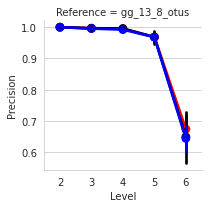

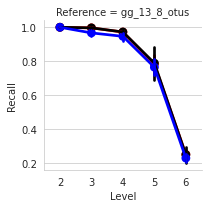

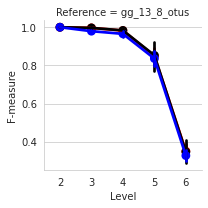

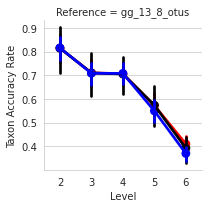

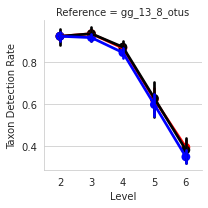

In [6]:
point = pointplot_from_data_frame(mock_results, "Level", y_vars, 
                                  group_by="Reference", color_by="Method",
                                  color_palette=color_palette)

In [7]:
for k, v in point.items():
    v.savefig(join(outdir, 'mock-{0}-lineplots.pdf'.format(k)))

Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database

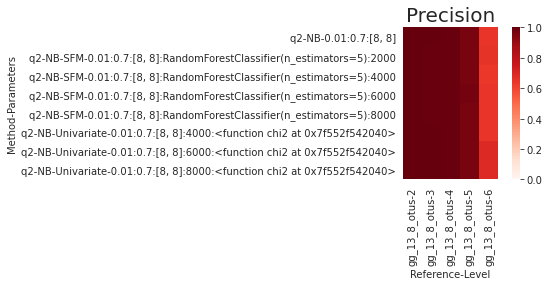

<AxesSubplot:title={'center':'Precision'}, xlabel='Reference-Level', ylabel='Method-Parameters'>

In [8]:
heatmap_from_data_frame(mock_results, metric="Precision", rows=["Method", "Parameters"], cols=["Reference", "Level"])

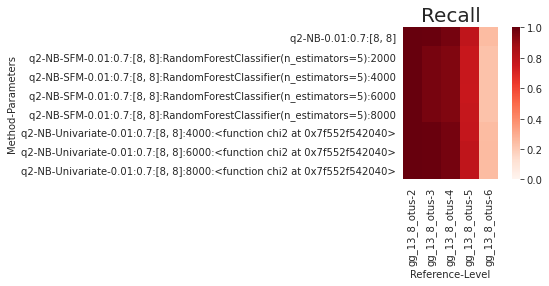

<AxesSubplot:title={'center':'Recall'}, xlabel='Reference-Level', ylabel='Method-Parameters'>

In [9]:
heatmap_from_data_frame(mock_results, metric="Recall", rows=["Method", "Parameters"], cols=["Reference", "Level"])

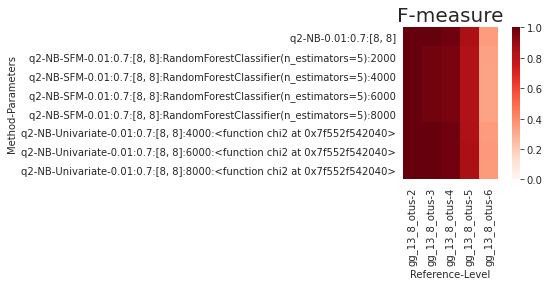

<AxesSubplot:title={'center':'F-measure'}, xlabel='Reference-Level', ylabel='Method-Parameters'>

In [10]:
heatmap_from_data_frame(mock_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Reference", "Level"])

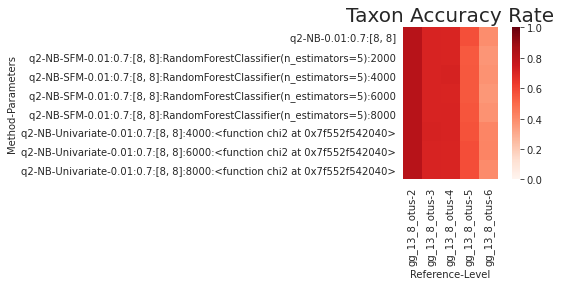

<AxesSubplot:title={'center':'Taxon Accuracy Rate'}, xlabel='Reference-Level', ylabel='Method-Parameters'>

In [11]:
heatmap_from_data_frame(mock_results, metric="Taxon Accuracy Rate", rows=["Method", "Parameters"], cols=["Reference", "Level"])

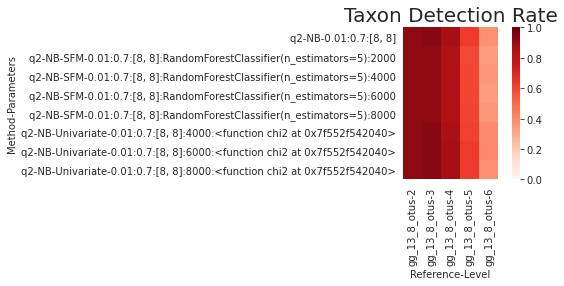

<AxesSubplot:title={'center':'Taxon Detection Rate'}, xlabel='Reference-Level', ylabel='Method-Parameters'>

In [12]:
heatmap_from_data_frame(mock_results, metric="Taxon Detection Rate", rows=["Method", "Parameters"], cols=["Reference", "Level"])

now we will focus on results at species level (for genus level, change to level 5)

Method optimization

Which method/parameter configuration performed "best" for a given score? We can rank the top-performing configuration by dataset, method, and taxonomic level.

First, the top-performing method/configuration combination by dataset.

In [23]:
pd.set_option('display.max_colwidth', None)
for dataset in mock_results_6['Dataset'].unique():
    display(Markdown('## {0}'.format(dataset)))
    best = method_by_dataset_a1(mock_results_6, dataset)
    display(best)

## mock-3

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
156,q2-NB-SFM,"0.01:0.7:[8, 8]:RandomForestClassifier(n_estim...",0.974959,0.330350,0.493488,0.588235,0.50
16,q2-NB-Univariate,"0.01:0.7:[8, 8]:6000:<function chi2 at 0x7f552...",0.918590,0.330350,0.485942,0.588235,0.50
76,q2-NB,"0.01:0.7:[8, 8]",0.890865,0.308252,0.458022,0.529412,0.45


## mock-2

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
164,q2-NB-Univariate,"0.01:0.7:[8, 8]:6000:<function chi2 at 0x7f552...",0.525779,0.412383,0.462228,0.450000,0.486486
179,q2-NB,"0.01:0.7:[8, 8]",0.478775,0.412383,0.443106,0.450000,0.486486
194,q2-NB-SFM,"0.01:0.7:[8, 8]:RandomForestClassifier(n_estim...",0.475069,0.367631,0.414501,0.410256,0.432432


## mock-4

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
216,q2-NB-Univariate,"0.01:0.7:[8, 8]:6000:<function chi2 at 0x7f552...",0.941840,0.404382,0.565825,0.52381,0.55
296,q2-NB-SFM,"0.01:0.7:[8, 8]:RandomForestClassifier(n_estim...",0.924560,0.404382,0.562666,0.52381,0.55
276,q2-NB,"0.01:0.7:[8, 8]",0.921122,0.385318,0.543346,0.47619,0.50


## mock-5

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
376,q2-NB-Univariate,"0.01:0.7:[8, 8]:6000:<function chi2 at 0x7f552...",0.931732,0.418752,0.577814,0.458333,0.55
496,q2-NB-SFM,"0.01:0.7:[8, 8]:RandomForestClassifier(n_estim...",0.886209,0.418752,0.568755,0.478261,0.55
436,q2-NB,"0.01:0.7:[8, 8]",0.928841,0.400496,0.559673,0.416667,0.50


## mock-6

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
594,q2-NB-SFM,"0.01:0.7:[8, 8]:RandomForestClassifier(n_estim...",0.514857,0.070339,0.123769,0.061224,0.055556
564,q2-NB-Univariate,"0.01:0.7:[8, 8]:4000:<function chi2 at 0x7f552...",0.430948,0.069258,0.119338,0.058824,0.055556
579,q2-NB,"0.01:0.7:[8, 8]",0.404475,0.069258,0.118266,0.074074,0.074074


## mock-8

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
654,q2-NB-Univariate,"0.01:0.7:[8, 8]:6000:<function chi2 at 0x7f552...",0.632625,0.367133,0.464627,0.422222,0.351852
699,q2-NB,"0.01:0.7:[8, 8]",0.632625,0.367133,0.464627,0.422222,0.351852
729,q2-NB-SFM,"0.01:0.7:[8, 8]:RandomForestClassifier(n_estim...",0.598372,0.317639,0.414987,0.340909,0.277778


## mock-1

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
764,q2-NB-Univariate,"0.01:0.7:[8, 8]:6000:<function chi2 at 0x7f552...",0.212413,0.090696,0.127116,0.333333,0.405405
779,q2-NB,"0.01:0.7:[8, 8]",0.212413,0.090696,0.127116,0.333333,0.405405
794,q2-NB-SFM,"0.01:0.7:[8, 8]:RandomForestClassifier(n_estim...",0.151776,0.058997,0.084966,0.325581,0.378378


## mock-7

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
829,q2-NB-Univariate,"0.01:0.7:[8, 8]:8000:<function chi2 at 0x7f552...",0.595432,0.339861,0.432729,0.44186,0.351852
859,q2-NB,"0.01:0.7:[8, 8]",0.595432,0.339861,0.432729,0.44186,0.351852
917,q2-NB-SFM,"0.01:0.7:[8, 8]:RandomForestClassifier(n_estim...",0.550989,0.274703,0.366622,0.30000,0.222222


Now we can determine which parameter configuration performed best for each method. Count best values in each column indicate how many samples a given method achieved within one mean absolute deviation of the best result (which is why they may sum to more than the total number of samples).

In [24]:
for method in mock_results_6['Method'].unique():
    top_params = parameter_comparisons(
        mock_results_6, method, 
        metrics=['Taxon Accuracy Rate', 'Taxon Detection Rate', 'Precision', 'Recall', 'F-measure'])
    display(Markdown('## {0}'.format(method)))
    display(top_params[:5])

## q2-NB-Univariate

,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
"0.01:0.7:[8, 8]:6000:<function chi2 at 0x7f552f542040>",19,20,17,20,17
"0.01:0.7:[8, 8]:8000:<function chi2 at 0x7f552f542040>",11,11,19,11,11
"0.01:0.7:[8, 8]:4000:<function chi2 at 0x7f552f542040>",10,12,4,15,9


## q2-NB

,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
"0.01:0.7:[8, 8]",23,23,23,23,23


## q2-NB-SFM

,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
"0.01:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):4000",11,9,9,16,11
"0.01:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):6000",8,7,7,13,10
"0.01:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):8000",14,11,9,9,9
"0.01:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):2000",7,7,9,7,8


Optimized method performance

And, finally, which method performed best at each individual taxonomic level for each reference dataset (i.e., for across all fungal and bacterial mock communities combined)?

For this analysis, we rank the top-performing method/parameter combination for each method at family through species levels. Methods are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered, unless if you wish to change the metric used for sorting best methods and for plotting.

## gg_13_8_otus level 4

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,q2-NB,"0.01:0.7:[8, 8]",0.705245,0.869478,0.995704,0.971763,0.983067
2,q2-NB-Univariate,"0.01:0.7:[8, 8]:6000:<function chi2 at 0x7f552...",0.705494,0.869478,0.995704,0.971763,0.983067
1,q2-NB-SFM,"0.01:0.7:[8, 8]:RandomForestClassifier(n_estim...",0.704514,0.843115,0.992395,0.946254,0.965276


stat         P  FDR P
Method A         Method B                            
q2-NB-Univariate q2-NB           NaN       NaN    NaN
                 q2-NB-SFM  1.965365  0.062122    NaN
q2-NB            q2-NB-SFM  1.965365  0.062122    NaN

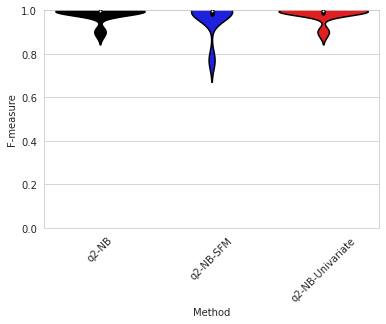

## gg_13_8_otus level 5

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,q2-NB,"0.01:0.7:[8, 8]",0.573593,0.626443,0.968450,0.788073,0.852590
2,q2-NB-Univariate,"0.01:0.7:[8, 8]:8000:<function chi2 at 0x7f552...",0.576186,0.626443,0.968450,0.788073,0.852590
1,q2-NB-SFM,"0.01:0.7:[8, 8]:RandomForestClassifier(n_estim...",0.555805,0.604465,0.968144,0.768753,0.839085


stat         P  FDR P
Method A         Method B                            
q2-NB-Univariate q2-NB           NaN       NaN    NaN
                 q2-NB-SFM  2.387798  0.025968    NaN
q2-NB            q2-NB-SFM  2.387798  0.025968    NaN

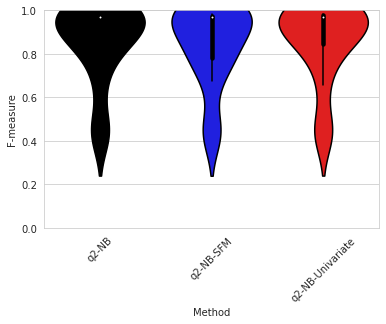

## gg_13_8_otus level 6

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
2,q2-NB-Univariate,"0.01:0.7:[8, 8]:6000:<function chi2 at 0x7f552...",0.419294,0.405203,0.689699,0.252804,0.355278
0,q2-NB,"0.01:0.7:[8, 8]",0.392084,0.381532,0.649591,0.248372,0.347058
1,q2-NB-SFM,"0.01:0.7:[8, 8]:RandomForestClassifier(n_estim...",0.364759,0.342146,0.652983,0.228264,0.328848


stat         P     FDR P
Method A         Method B                               
q2-NB-Univariate q2-NB      3.278007  0.003437  0.005155
                 q2-NB-SFM  4.018802  0.000576  0.001728
q2-NB            q2-NB-SFM  2.469681  0.021758  0.021758

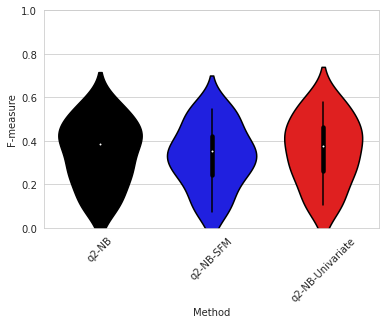

In [25]:
boxes = rank_optimized_method_performance_by_dataset(mock_results,
                                                     dataset="Reference",
                                                     metric="F-measure",
                                                     level_range=range(4,7),
                                                     display_fields=["Method",
                                                                     "Parameters",
                                                                     "Taxon Accuracy Rate",
                                                                     "Taxon Detection Rate",
                                                                     "Precision",
                                                                     "Recall",
                                                                     "F-measure"],
                                                     paired=True,
                                                     parametric=True,
                                                     color=None,
                                                     color_palette=color_palette)